In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Preprocessing images
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def load_images_labels(dataset_path, img_size=128):
    images = []
    labels = []

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                # Load the image using OpenCV and convert it to grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                # Resize the image to a larger common size (e.g., 128x128 pixels)
                image = cv2.resize(image, (img_size, img_size))
                # Convert grayscale to RGB by replicating the gray channel to three channels
                image = np.stack((image,)*3, axis=-1)
                # Normalize pixel values to the range [0, 1]
                image = image / 255.0
                # Append the image and label to lists
                images.append(image)
                labels.append(class_name)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

img_path = '/kaggle/input/covid19-balanced/content/COVID19_balanced'

# Load train and test data
images, labels = load_images_labels(img_path)

# Encoding labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

onehot_encoder = OneHotEncoder(sparse_output=False)
labels_encoded = labels_encoded.reshape(-1, 1)
labels_onehot = onehot_encoder.fit_transform(labels_encoded)

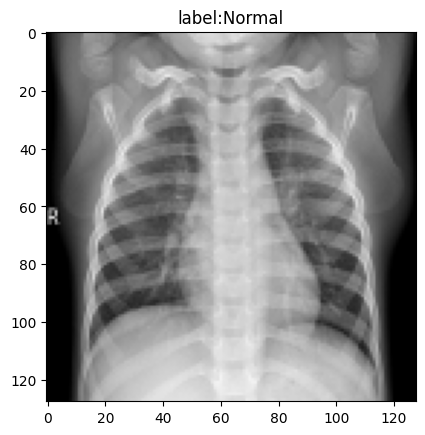

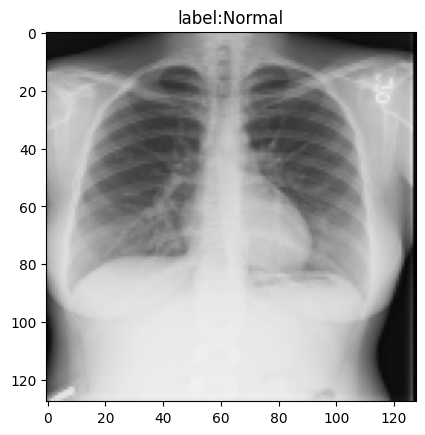

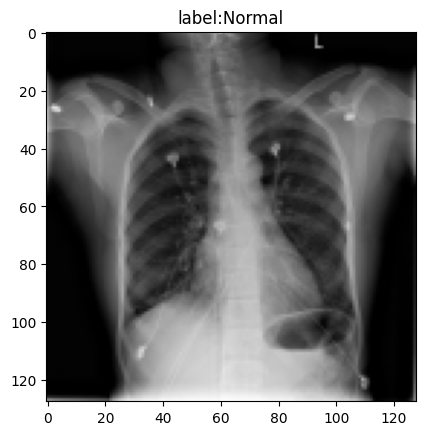

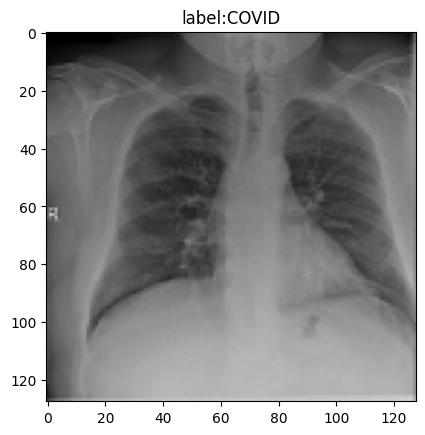

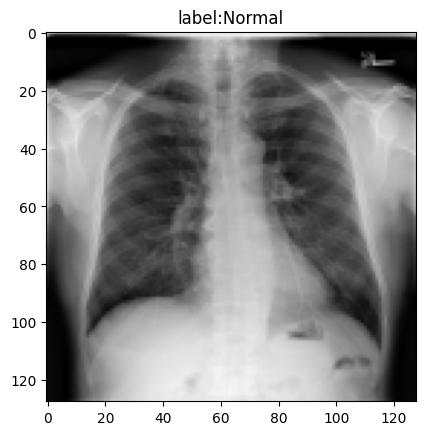

In [3]:
#Visualizing the images with labels
import matplotlib.pyplot as plt
r = np.random.choice(len(images), 5, replace=False)

for i in r:
    plt.imshow(images[i],cmap='gray')
    plt.title(f'label:{labels[i]}')
    plt.show()

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels_onehot, test_size=0.15, random_state=0)
print("X_train data shape:", X_train.shape)
print("X_test data shape:", X_test.shape)
print("y_train data shape:", y_train.shape)
print("y_test data shape:", y_test.shape)

X_train data shape: (5833, 128, 128, 3)
X_test data shape: (1030, 128, 128, 3)
y_train data shape: (5833, 2)
y_test data shape: (1030, 2)


In [5]:
(X_train, X_val, y_train, y_val) = train_test_split(X_train, y_train, test_size=0.05, random_state=0)
print("X_train data shape:", X_train.shape)
print("X_val data shape:", X_val.shape)
print("y_train data shape:", y_train.shape)
print("y_val data shape:", y_val.shape)

X_train data shape: (5541, 128, 128, 3)
X_val data shape: (292, 128, 128, 3)
y_train data shape: (5541, 2)
y_val data shape: (292, 2)


In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen = datagen.flow(X_train, y_train, batch_size=44)

In [7]:
import numpy as np
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(24))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.4))

model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                        

In [8]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=80, 
                    validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/30


2024-08-24 09:05:55.434368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - 8s 50ms/step - loss: 0.5487 - accuracy: 0.7528 - val_loss: 0.8223 - val_accuracy: 0.5171 - lr: 1.0000e-05
Epoch 2/30
70/70 [==============================] - 3s 41ms/step - loss: 0.4447 - accuracy: 0.8347 - val_loss: 0.9429 - val_accuracy: 0.5171 - lr: 1.0000e-05
Epoch 3/30
70/70 [==============================] - 3s 41ms/step - loss: 0.4062 - accuracy: 0.8701 - val_loss: 0.9424 - val_accuracy: 0.5171 - lr: 1.0000e-05
Epoch 4/30
70/70 [==============================] - 3s 41ms/step - loss: 0.3809 - accuracy: 0.8946 - val_loss: 0.8517 - val_accuracy: 0.5171 - lr: 1.0000e-05
Epoch 5/30
70/70 [==============================] - 3s 41ms/step - loss: 0.3653 - accuracy: 0.9065 - val_loss: 0.7689 - val_accuracy: 0.5171 - lr: 2.0000e-06
Epoch 6/30
70/70 [==============================] - 3s 41ms/step - loss: 0.3605 - accuracy: 0.9065 - val_loss: 0.6641 - val_accuracy: 0.5205 - lr: 2.0000e-06
Epoch 7/30
70/70 [==============================] - 3s 41ms/ste

In [9]:
print('Final training loss ', history.history['loss'][-1])
print('Final training accuracy ', history.history['accuracy'][-1])

Final training loss  0.3045489192008972
Final training accuracy  0.95470130443573


In [10]:
testLoss, testAccuracy = model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 7ms/step - loss: 0.3203 - accuracy: 0.9330


In [11]:
print('Testing loss ', testLoss)
print('Testing accuracy ', testAccuracy)

Testing loss  0.320321649312973
Testing accuracy  0.933009684085846


In [12]:
y_pred = model.predict(X_test)

y_pred_class = np.argmax(y_pred, axis = 1)

y_true = np.argmax(y_test,axis = 1)

33/33 [==============================] - 0s 4ms/step


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_class))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       523
           1       0.93      0.93      0.93       507

    accuracy                           0.93      1030
   macro avg       0.93      0.93      0.93      1030
weighted avg       0.93      0.93      0.93      1030



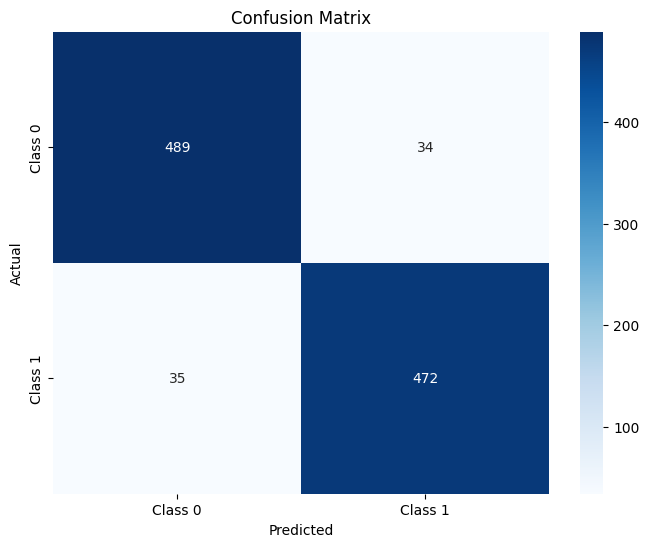

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_true, y_pred_class, class_names=['Class 0', 'Class 1'])